In [37]:
#https://www.kaggle.com/buchan/transformer-network-with-1d-cnn-feature-extraction
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K
from keras import metrics

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.random.set_seed(368)

In [38]:
%%time
# train_df = pd.read_csv('./input/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})#Original
train_df = pd.read_csv('C:/Users/malco/aaPythonPersonalNotebook/1DCNN/input/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

Wall time: 1min 34s


In [39]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [40]:
X_train = train_df.acoustic_data.values
print('X_train:',X_train)
y_train = train_df.time_to_failure.values
print('_ytrain:',y_train)

X_train: [12  6  8 ... 10  6  5]
_ytrain: [1.4691   1.4691   1.4691   ... 9.759795 9.759795 9.759795]


Find complete segments in the training data (time to failure goes to zero)

In [41]:
ends_mask = np.less(y_train[:-1], y_train[1:]) #Return the truth value of (x1 < x2) element-wise.
print('ends_mask:',ends_mask)
segment_ends = np.nonzero(ends_mask)#Return the indices of the elements that are non-zero.
print('\nsegment_ends:',segment_ends)
train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

ends_mask: [False False False ... False False False]

segment_ends: (array([  5656573,  50085877, 104677355, 138772452, 187641819, 218652629,
       245829584, 307838916, 338276286, 375377847, 419368879, 461811622,
       495800224, 528777114, 585568143, 621985672], dtype=int64),)
[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


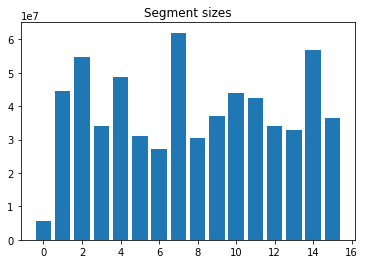

In [42]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])


The generator samples randomly from the segmens without crossing the boundaries

In [43]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
        segment = self.segments[segment_index]
        end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        #x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

We could use any segments for training / validation

In [44]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [45]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)

4.472289301190891 6.189013535612676


In [46]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

In [47]:
print(train_gen)

Use convolutional layers to learn the features and reduce the time sequence length 

In [48]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass

embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [49]:
def CnnTransformerModel():
    i = Input(shape = (150000, 1))
    
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(i)

    x = Convolution1D( 8, kernel_size = 10, strides = 10, activation='relu')(x)
    
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)

    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)

    x = Convolution1D(32, kernel_size = 10, strides = 10, activation='relu')(x)
    
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)

    x = Convolution1D(64, kernel_size = 10, strides = 10, activation='relu')(x)

    x = Bidirectional(LSTM(128, return_sequences = True, return_state = False))(x)
    
    x = Bidirectional(LSTM(64, return_sequences = True, return_state = False))(x)
    
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    
    avg_pool = Dense(60,activation = 'relu')(avg_pool)
    
    y = Dense(1,activation = 'relu')(avg_pool)
    

    return Model(inputs = [i], outputs = [y])

In [50]:
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.4.3
2.4.1


In [51]:
from keras.layers import Bidirectional, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

model = CnnTransformerModel()
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150000, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 150000, 1)    4           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 15000, 8)     88          batch_normalization_8[0][0]      
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 15000, 8)     32          conv1d_8[0][0]                   
____________________________________________________________________________________________

**Visualizing The Model Architecture**

In [53]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [54]:
import time
start_time = time.time()
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 25, 
    verbose = 1, 
    validation_data = valid_gen,
)
print("--- %s seconds ---" % (time.time() - start_time))

c:\users\malco\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
400/400 [==============================] - 266s 652ms/step - loss: 9.6155 - mean_absolute_error: 2.2922 - val_loss: 7.2123 - val_mean_absolute_error: 2.1219
Epoch 2/25
400/400 [==============================] - 298s 746ms/step - loss: 6.1809 - mean_absolute_error: 1.8511 - val_loss: 6.4402 - val_mean_absolute_error: 1.9168
Epoch 3/25
400/400 [==============================] - 275s 687ms/step - loss: 6.2972 - mean_absolute_error: 1.8275 - val_loss: 6.9817 - val_mean_absolute_error: 1.9549
Epoch 4/25
400/400 [==============================] - 264s 661ms/step - loss: 6.1848 - mean_absolute_error: 1.8459 - val_loss: 8.5071 - val_mean_absolute_error: 2.2128
Epoch 5/25
400/400 [==============================] - 255s 636ms/step - loss: 5.9706 - mean_absolute_error: 1.7958 - val_loss: 8.2901 - val_mean_absolute_error: 2.1938
Epoch 6/25
400/400 [==============================] - 47505s 119s/step - loss: 5.9265 - mean_absolute_error: 1.8040 - val_loss: 7.0146 - val_mean_absolute_error

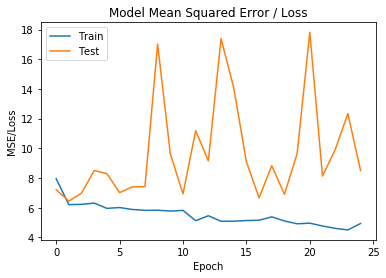

In [55]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Mean Squared Error / Loss')
plt.ylabel('MSE/Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

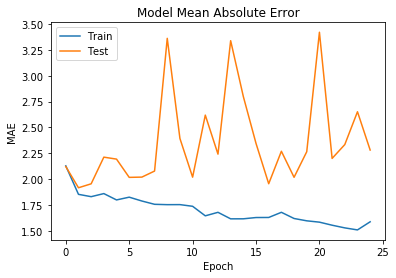

In [56]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [57]:
import gc
del train_gen
del valid_gen
del X_train
del y_train
del train_df
gc.collect()


5892

In [58]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [75]:
def load_test(ts_length = 150000):
#     base_dir = '../input/test/'#C:/Users/malco/aaPythonPersonalNotebook/1DCNN/input/train.csv
    base_dir = 'C:/Users/malco/aaPythonPersonalNotebook/1DCNN/input/test/'#C:/Users/malco/aaPythonPersonalNotebook/1DCNN/input/train.csv
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [79]:
test_data, test_ids = load_test()

c:\users\malco\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/2624 [00:00<?, ?it/s]

In [80]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

Load best model and predict

In [84]:
y_pred = model.predict(X_test)
y_pred

array([[ 4.998331 ],
       [ 7.175854 ],
       [ 8.554479 ],
       ...,
       [ 2.8969786],
       [ 2.7710319],
       [11.132894 ]], dtype=float32)

In [82]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [83]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>

